# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter

In [8]:
X_test = pd.read_csv('input/X_test.csv', index_col=[0,1])
X_train = pd.read_csv('input/X_train.csv', index_col=[0,1])
y_train = pd.read_csv('input/y_train.txt', header=None, sep='+')
y_test = pd.read_csv('input/y_test.txt', header=None, sep='+')

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.25, random_state=2309)

### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [15]:
clf = DecisionTreeClassifier(random_state=2309, max_depth=4)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=2309)

Filtrando as 3 variáveis de maior importância com `clf.feature_importances_`:

In [17]:
importance = clf.feature_importances_
var = X_train.columns

df_importance = pd.DataFrame({'var': var,
                              'importancia': importance
                              })
df_importance.sort_values(by='importancia', ascending=False)

,var,importancia
40,tGravityAcc-mean()-X,0.279153
86,tBodyAccJerk-mad()-X,0.255797
559,"angle(Y,gravityMean)",0.168411
504,fBodyAccMag-mad(),0.138977
73,"tGravityAcc-arCoeff()-Z,1",0.117242
...,...,...
185,"tBodyGyroJerk-arCoeff()-X,1",0.000000
184,tBodyGyroJerk-entropy()-Z,0.000000
183,tBodyGyroJerk-entropy()-Y,0.000000
182,tBodyGyroJerk-entropy()-X,0.000000


Seleção da 3 variáveis de maior importância:

In [39]:
X_train = X_train[['tGravityAcc-mean()-X', 'tBodyAccJerk-mad()-X', 'angle(Y,gravityMean)']]
X_valid = X_valid[['tGravityAcc-mean()-X', 'tBodyAccJerk-mad()-X', 'angle(Y,gravityMean)']]
X_test = X_test[['tGravityAcc-mean()-X', 'tBodyAccJerk-mad()-X', 'angle(Y,gravityMean)']]

### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [31]:
%%time
clf = DecisionTreeClassifier(random_state=2309)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

CPU times: total: 46.9 ms
Wall time: 46.9 ms


Verificando valores negativos e duplicados:

In [32]:
negativos = ccp_alphas[ccp_alphas < 0]
duplicados = [item for item, count in Counter(ccp_alphas).items() if count > 1]
print(f'Valores negativos em ccp_alphas: {negativos}')
print(f'Valores duplicados em ccp_alphas: {duplicados}')

Valores negativos em ccp_alphas: []
Valores duplicados em ccp_alphas: [0.00013601741022850925, 0.0001450852375770765, 0.00015113045580945474, 0.00015544846883258203, 0.00015868697859992747, 0.00016322089227421114, 0.00016740604335816516, 0.00016840250790196387, 0.00016926611050658934, 0.00017181146555180125, 0.00017228871962277835, 0.00018135654697134566, 0.00021762785636561478, 0.00024180872929512753, 0.00025389916575988393, 0.000253899165759884, 0.0002720348204570185, 0.000290170475154153, 0.00031089693766516406, 0.00031737395719985494, 0.00032241163906017006, 0.0003264417845484223, 0.0003297391763115376, 0.0003517217880656402]


Tratando os valores duplicados encontrados:

In [33]:
ccp_alphas = np.unique(ccp_alphas)
duplicados = [item for item, count in Counter(ccp_alphas).items() if count > 1]
print(f'Valores duplicados em ccp_alphas: {duplicados}')

Valores duplicados em ccp_alphas: []


Rodando uma árvore para cada `ccp_alpha`:

In [34]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2309, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)

Calculando a acurácia de cada árvore na base de treino e validação:

In [35]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
valid_scores  = [clf.score(X_valid, y_valid) for clf in clfs]

Plotando gráfico da acurácia em função do `ccp_alpha` para a base de treino e validação:

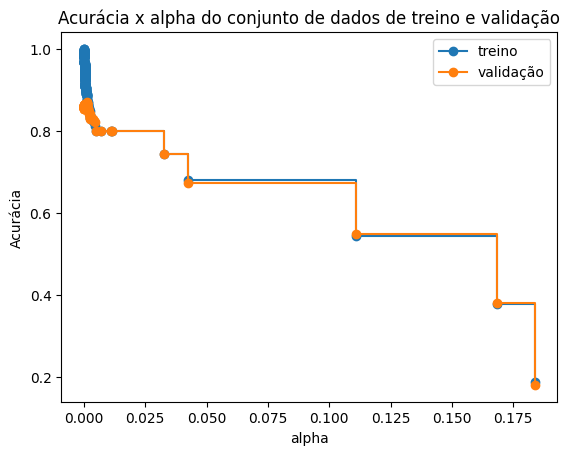

In [36]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.legend()
plt.show()

Selecionando a melhor árvore como sendo aquela com a melhor acurácia na base de validação:

In [37]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 86.94


DecisionTreeClassifier(ccp_alpha=0.001182271965732248, random_state=2309)

### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

Acurácia: 68.68


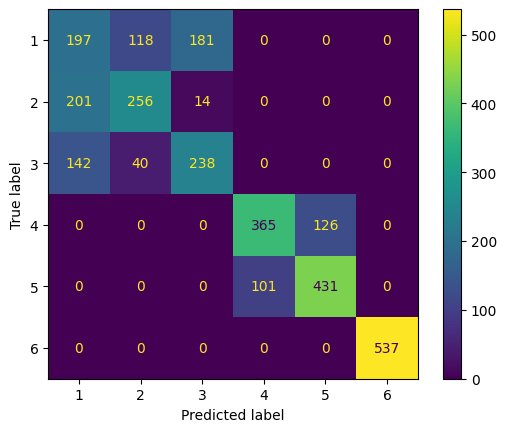

In [40]:
print(f'Acurácia: {melhor_arvore.score(X_test, y_test)*100:.2f}')
ConfusionMatrixDisplay.from_estimator(melhor_arvore, X_test, y_test);